In previous posts, we've seen how to solve elliptic PDE, sometimes with constraints, assuming we know everything about the coefficients and other input data.
Some problems in geophysics and engineering involve going backwards.
We have direct measurements of some field that we know is the solution of a PDE, and from that data we want to estimate what the coefficients were.
This is what's called an *inverse problem*.
For example, knowing the inflow rate of groundwater and the degree to which the soil and bedrock are porous, we can calculate what the hydraulic head will be by solving the Poisson equation; this is the forward problem.
The inverse problem would be to estimate the porosity from measurements of the hydraulic head.

We've already seen many of the techniques that we'll use to solve inverse problems and in this post I'll demonstrate them.
Inverse problems can be expressed through PDE-constrained optimization, and the biggest challenge is calculating the gradient of the objective functional with respect to the input parameters.
There's a systematic and practical algorithm to do this called the [adjoint method](https://journals.ametsoc.org/bams/article/78/11/2577/55799/What-Is-an-Adjoint-Model).
The UFL language for variational forms preserves enough of the high-level semantics of what problem you're solving, and consequently it's possible to generate all of the code necessary to implement the adjoint method solely from the code for the weak form.
The package [pyadjoint](http://www.dolfin-adjoint.org/en/latest/) does this and even won a Wilkinson Prize for numerical software.
In the following, I'll use pyadjoint to both calculate derivatives and solve optimization problems, but it's instructive to roll your own adjoint method and solvers if you haven't done it before.

### The problem

Suppose that the physics we're interested in can be described by the Poisson problem.
We want to estimate is the conductivity coefficient and we have measurements of the solution $u$.
Rather than solve for the conductivity $K$ itself, I'll instead assume that the field $q$ that we want to infer is the logarithm of the conductivity:

$$K = ke^q,$$

where $k$ is some real constant.
The reason for this change of variables is to guarantee that the conductivity is positive, a necessary condition which can be challenging to enforce through other means.
For our problem, we'll include some internal sources $f$.
By way of boundary conditions, we'll assume that the solution is adjusts with some exchange coefficient $h$ to an external field $g$ (these are *Robin* boundary conditions).
The weak form of this equation is

$$\begin{align}
\langle F(u, q), v\rangle = & \int_\Omega\left(ke^q\nabla u\cdot\nabla v - fv\right)dx \\
& \qquad\qquad + \int_{\partial\Omega}h(u - g)v\, ds
\end{align}$$

I'll assume that we know the sources, external field, and exchange coefficient accurately.
The quantity that we want to minimize is the mean-square misfit of the solution $u$ with some observations $u^o$:

$$E(u) = \frac{1}{2}\int_\Omega\left(\frac{u - u^o}{\sigma}\right)^2dx,$$

where $\sigma$ is the standard deviation of the measurement errors in $u^o$.
For realistic problems we might want to consider more robust measures of solution quality, like the 1-norm, but for demonstrative purposes the square norm is perfectly fine.

To make our problem as realistic as possible, we'll create a set of synthetic observations that's been polluted from the true value with random noise.
The presence of noise introduces an additional challenge.
The map from the parameters $q$ to the observations $u$ involves solving an elliptic PDE and thus tends to give an output field $u$ that is smoother than the input field $q$.
(You can actually write down an analytical form of the linearization of this map that makes the smoothing property evident.)
For many practical problems, however, the measurement errors are spatial white noise, which have equal power at all frequencies.
If we put white noise through the inverse of a smoothing operator, we'll end up amplifying the high-frequency modes and the estimated field $q$ will be polluted with spurious osillations.
To remove these unphysical features, we'll also include some metric of how oscillatory the inferred field is, which in our case will be

$$R(q) = \frac{1}{2}\int_\Omega|\nabla q|^2dx.$$

This is called the **regularization functional**.
Depending on the problem you may want to use a different regularization functional, and at the end of this post I'll give an example of when you might want to do that.

### All together now

The quantity we want to minimize is the functional

$$J(u, q) = E(u) + \alpha^2 R(q),$$

subject to the constraint that $u$ and $q$ are related by the PDE, which we'll write in abstract form as $F(u, q) = 0$.
The parameter $\alpha$ is a length scale that determines how much we want to regularize the inferred field.
Making a good choice of $\alpha$ is a bit of an art form best left for another day; in the following demonstration I'll pick a reasonable value and leave it at that.
The adjoint method furnishes us with a way to calculate the derivative of $J$, which will be an essential ingredient in any minimization algorithm.

To be more explicit about enforcing those constraints, we can introduce a Lagrange multiplier $\lambda$.
We would then seek a critical point of the Lagrangian

$$L(u, q, \lambda) = E(u) + \alpha^2 R(q) + \langle F(u, q), \lambda\rangle.$$

By first solving for $u$ and then for the adjoint state $\lambda$, we can effectively calculate the derivative of our original objective with respect to the parameters $q$.
Under the hood, this is exactly what pyadjoint and (more generally) reverse-mode automatic differentiation does.
The interface that pyadjoint presents to us hides the existence of a Lagrange multiplier and instead gives us only a *reduced* functional $\hat J(q)$.

### Generating the exact data

First, we'll need to make a domain and some synthetic input data, which consist of:

* the sources $f$
* the external field $g$
* the exchange coefficient $h$
* the true log-conductivity field $q$

We have to be careful about what kind of data we use in order to make the problem interesting and instructive.
Ideally, the the true log-conductivity field will give a solution that's very different from some kind of blunt, spatially constant initial guess.
To do this, we'll first make the external field $g$ a random trigonometric polynomial.

In [1]:
import firedrake
mesh = firedrake.UnitSquareMesh(32, 32, diagonal='crossed')
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)
V = firedrake.FunctionSpace(mesh, family='CG', degree=2)

In [2]:
import numpy as np
from numpy import random, pi as π
x = firedrake.SpatialCoordinate(mesh)

rng = random.default_rng(seed=1)
def random_fourier_series(std_dev, num_modes, exponent):
    from firedrake import sin, cos
    A = std_dev * rng.standard_normal((num_modes, num_modes))
    B = std_dev * rng.standard_normal((num_modes, num_modes))
    return sum([(A[k, l] * sin(π * (k * x[0] + l * x[1])) +
                 B[k, l] * cos(π * (k * x[0] + l * x[1])))
                / (1 + (k**2 + l**2)**(exponent/2))
                for k in range(num_modes)
                for l in range(int(np.sqrt(num_modes**2 - k**2)))])

In [3]:
g = firedrake.Function(V).interpolate(random_fourier_series(1.0, 6, 1))

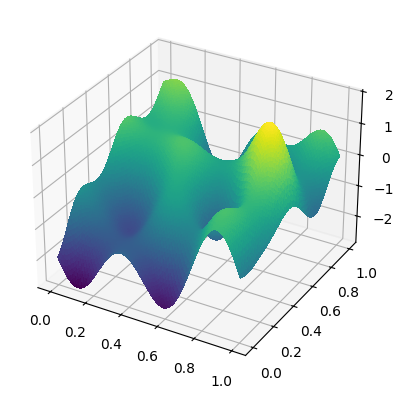

In [4]:
import matplotlib.pyplot as plt
firedrake.trisurf(g);

Next, we'll make the medium much more insulating (lower conductivity) near the center of the domain.
This part of the medium will tend to soak up any sources much more readily than the rest.

In [5]:
from firedrake import inner, min_value, max_value, Constant
a = -Constant(8.)
r = Constant(1/4)
ξ = Constant((0.4, 0.5))
expr = a * max_value(0, 1 - inner(x - ξ, x - ξ) / r**2)
q_true = firedrake.Function(Q).interpolate(expr)

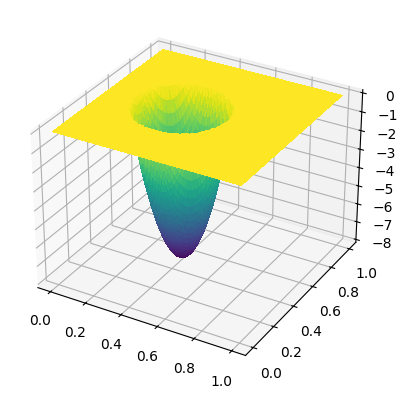

In [6]:
firedrake.trisurf(q_true);

In order to make the effect most pronounced, we'll stick a blob of sources right next to this insulating patch.

In [7]:
b = Constant(6.)
R = Constant(1/4)
η = Constant((0.7, 0.5))
expr = b * max_value(0, 1 - inner(x - η, x - η) / R**2)
f = firedrake.Function(V).interpolate(expr)

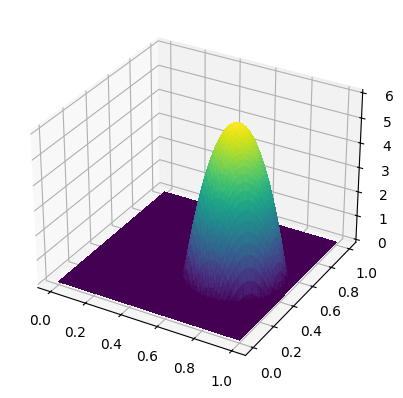

In [8]:
firedrake.trisurf(f);

Once we pick a baseline value $k$ of the conductivity and the exchange coefficient $h$, we can compute the true solution.
We'll take the exchange coefficient somewhat arbitrarily to be 10 in this unit system because it makes the results look nice enough.

In [9]:
from firedrake import exp, grad, dx, ds
k = Constant(1.)
h = Constant(10.)
u_true = firedrake.Function(V)
v = firedrake.TestFunction(V)
F = (
    (k * exp(q_true) * inner(grad(u_true), grad(v)) - f * v) * dx +
    h * (u_true - g) * v * ds
)

In [10]:
opts = {
    'solver_parameters': {
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
}
firedrake.solve(F == 0, u_true, **opts)

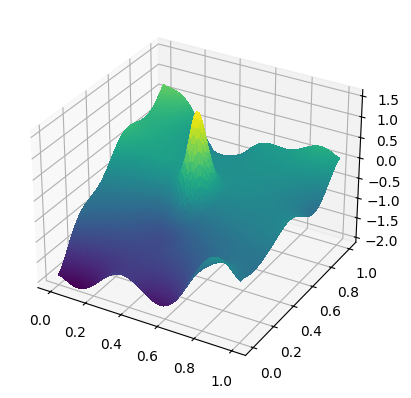

In [11]:
firedrake.trisurf(u_true);

The true value of $u$ has a big hot spot in the insulating region, just as we expect.

### Generating the observational data

For realistic problems, what we observe is the true solution plus some random noise $\xi$:

$$u_\text{obs} = u_\text{true} + \xi.$$

The ratio of the variance $\sigma$ of the noise to some scale of the solution, e.g. $\max_\Omega u_\text{true} - \min_\Omega u_\text{true}$, will determine the degree of accuracy that we can expect in the inferred field.

To make this experiment more realistic, we'll synthesize some observations by adding random noise to the true solution.
We'll assume that the noise is spatially white, i.e. the covariance of the measurement errors is

$$\mathbb{E}[\xi(x)\xi(y)] = \sigma^2\delta(x - y)$$

where $\delta$ is the Dirac delta distribution.
A naive approach would be to add a vector of normal random variables to the finite element expansion coefficients of the true solution, but this will fail for a subtle reason.
Suppose that, at every point, the measurement errors $\xi$ are normal with mean 0 and variance $\sigma$.
Letting $\mathbb{E}$ denote statistical expectation, we should then have by Fubini's theorem that

$$\mathbb{E}\left[\int_\Omega\xi(x)^2dx\right] = \int_\Omega\mathbb{E}[\xi(x)^2]dx = \sigma^2\cdot|\Omega|.$$

The naive approach to synthesizing the noise will give us the wrong value of the area-averaged variance.

In [12]:
ξ = firedrake.Function(V)
n = len(ξ.dat.data_ro)
ξ.dat.data[:] = rng.standard_normal(n)

firedrake.assemble(ξ**2 * dx)

np.float64(0.6237269211354283)

The "right" thing to do is:

1. Compute the finite element mass matrix $M$
2. Compute the Cholesky factorization $M = LL^*$
3. Generate a standard normal random vector $z$
4. The finite element expansion coefficients for the noise vector are

$$\hat\xi = \sigma\sqrt{\frac{|\Omega|}{n}}L^{-*}z.$$

You can show that this works out correctly by remembering that

$$\int_\Omega\xi^2dx = \hat\xi^*M\hat\xi.$$

We'll have to do a bit of hacking with PETSc data structures directly in order to pull out one of the Cholesky factors of the mass matrix.

In [13]:
from firedrake.petsc import PETSc
ϕ, ψ = firedrake.TrialFunction(V), firedrake.TestFunction(V)
m = inner(ϕ, ψ) * dx
M = firedrake.assemble(m, mat_type='aij').M.handle
ksp = PETSc.KSP().create()
ksp.setOperators(M)
ksp.setUp()
pc = ksp.pc
pc.setType(pc.Type.CHOLESKY)
pc.setFactorSolverType(PETSc.Mat.SolverType.PETSC)
pc.setFactorSetUpSolverType()
L = pc.getFactorMatrix()
pc.setUp()

Since our domain is the unit square, it has an area of 1, but for good measure I'll include this just to show the correct thing to do.

In [14]:
area = firedrake.assemble(Constant(1) * dx(mesh))

In [15]:
z = firedrake.Function(V)
z.dat.data[:] = rng.standard_normal(n)
with z.dat.vec_ro as Z:
    with ξ.dat.vec as Ξ:
        L.solveBackward(Z, Ξ)
        Ξ *= np.sqrt(area / n)

The error statistics are within spitting distance of the correct value of 1.

In [16]:
firedrake.assemble(ξ**2 * dx) / area

np.float64(0.9898623684079143)

The answer isn't exactly equal to one, but averaged over a large number of trials or with a larger mesh it will approach it.
Finally, we can make the "observed" data.
We'll use a signal-to-noise ratio of 50, but it's worth tweaking this value and seeing how the inferred parameters change.

In [17]:
û = u_true.dat.data_ro[:]
signal = û.max() - û.min()
signal_to_noise = 50
σ = firedrake.Constant(signal / signal_to_noise)

u_obs = u_true.copy(deepcopy=True)
u_obs += σ * ξ

The high-frequency noise you can see in the plot below is exactly what makes regularization necessary.

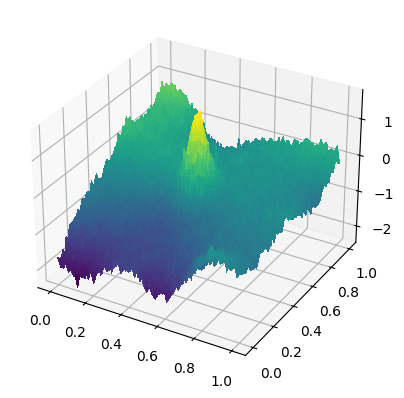

In [18]:
firedrake.trisurf(u_obs);

### Calculating derivatives

Now we can import firedrake-adjoint.
Under the hood, this will initialize the right data structures to calculate derivatives using the adjoint method, and we can even take a peek at those data structures.

In [19]:
import firedrake.adjoint
firedrake.adjoint.continue_annotation()

True

We'll start with a fairly neutral initial guess that the log-conductivity $q$ is identically 0.

In [20]:
q = firedrake.Function(Q)
u = firedrake.Function(V)
F = (
    (k * exp(q) * inner(grad(u), grad(v)) - f * v) * dx +
    h * (u - g) * v * ds
)
firedrake.solve(F == 0, u, **opts)

The computed solution with a constant conductivity doesn't have the gigantic spike in the insulating region, so it's very easy to tell them apart.
When the differences are really obvious it makes it easier to benchmark a putative solution procedure.

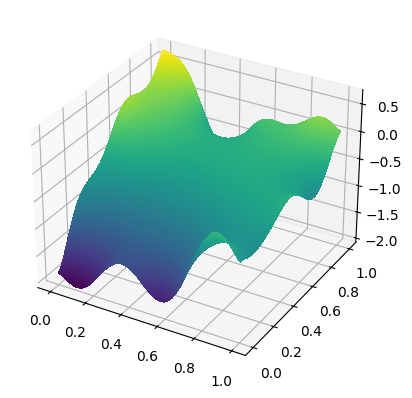

In [21]:
firedrake.trisurf(u);

Just to give a sense of how different the initial value of the observed field is from the true value, we can calculate the relative difference in the 2-norm:

In [22]:
print(firedrake.norm(u - u_true) / firedrake.norm(u_true))

0.2985859425270404


Now we can start having some fun with Firedrake's adjoint capabilities.
A lot of what we're going to do can seem like magic and I often find it a little bewildering to have no idea what's going on under the hood.
Much of this machinery works by overloading functionality within Firedrake and recording operations to a *tape*.
The tape can then in effect be played backwards to perform reverse-mode automatic differentiation.
You can access the tape explicitly from the Firedrake adjoint API, which conveniently provides functions to visualise the tape using [graphviz](https://graphviz.org/) or [NetworkX](https://networkx.org).
The plot below shows the overall connectivity of the structure of the tape; you can query the nodes using NetworkX to get a better idea of what each one represents.
This tape will grow and grow as we calculate more things and it's a common failure mode for an adjoint calculation to eat up all the system memory if you're not careful.

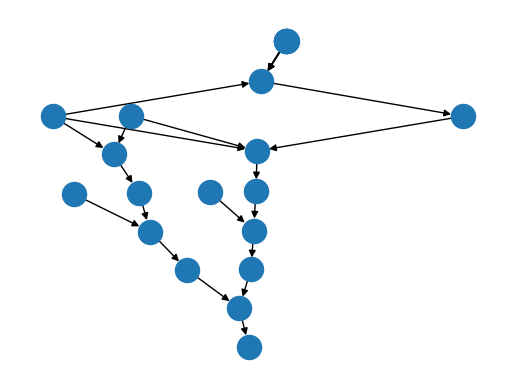

In [23]:
import networkx
tape = firedrake.adjoint.get_working_tape()
graph = tape.create_graph(backend='networkx')
fig, axes = plt.subplots()
networkx.draw_kamada_kawai(graph, ax=axes);

Hopefully this gives you some sense of how all this machinery works at a lower level.
For more details you can see the [dolfin-adjoint](http://www.dolfin-adjoint.org/en/latest/) documentation, which has loads of commentary on both the math and the code by its author, Patrick Farrell.

To start on solving the inverse problem, we're going to declare that $q$ is the *control variable*, i.e. it's the thing that want to optimize over, as opposed to the field $u$ that we can observe.

In [24]:
q̂ = firedrake.adjoint.Control(q)

Next we'll create the objective functional, which measures both the degree to which our computed solution $u$ differs from the true solution and the oscillations in our guess $q$.
Normally, we might create a symbolic variable (a Firedrake `Form` type) that represents this functional.
If we wanted to get an actual number out of this symbolic object, we would then call `assemble`.
So it might stick out as unusual that we're assembling the form right away here.

In [25]:
α = Constant(5e-2)
J = firedrake.assemble(
    0.5 * ((u - u_obs) / σ)**2 * dx +
    0.5 * α**2 * inner(grad(q), grad(q)) * dx
)

In fact there's a bit of magic going under the hood; `J` isn't really a floating point number, but a more complex object defined within the pyadjoint package.
The provenance of how this number is calculated is tracked through the adjoint tape.

In [26]:
print(type(J))

<class 'pyadjoint.adjfloat.AdjFloat'>


We can get an actual number out of this object by casting it to a `float`.

In [27]:
print(float(J))

4.975344431060689


The advantage of having this extra layer of indirection is that, as the control variable $q$ changes, so does $J$ and firedrake-adjoint will track the sensitivity under the hood for you.
The next step is to somehow wire up this functional with the information that $u$ isn't really an independent variable, but rather a function of the control $q$.
This is what the `ReducedFunctional` class does for us.

In [28]:
Ĵ = firedrake.adjoint.ReducedFunctional(J, q̂)

The reduced functional has a method to calculate its derivative with respect to the control variable.

In [29]:
dĴ_dq = Ĵ.derivative()

This method call is hiding some subtleties that are worth unpacking.
The reduced functional $\hat J$ is a differentiable mapping of the function space $Q$ into the real numbers.
The derivative $d\hat J/dq$ at a particular value of the control variable is an element of the dual space $Q^*$.
As mathematicians, we grow accustomed to thinking of Hilbert spaces as being isometric to their duals.
It's easy to forget that isometric does not mean identical; the mapping between primal and dual can be non-trivial.
For example, suppose $Q$ is the Sobolev space $H^1(\Omega)$.
The dual space $H^{-1}(\Omega)$ is isometric to the primal, *but* to evaluate the mapping between them, we have to solve an elliptic PDE.

The Sobolev space $H^1(\Omega)$ is a relatively tame one in the grand scheme of things.
Real problems might involve controls in Banach spaces with no inner product structure at all.
For example, the conductivity coefficient has to be bounded and positive, so we're probably looking in some cone in the space $L^\infty(\Omega)$.
In general, conductivity fields can be discontinuous, although not wildly so.
We might then want to look in the intersection of $L^\infty$ with the space [$BV(\Omega)$](https://en.wikipedia.org/wiki/Bounded_variation) of functions whose first derivatives are finite signed measures.

Nonetheless, the discretization via finite elements can obscure the distinction between the primal and dual spaces.
The control $q$ and the derivative $d\hat J/dq$ contain within them a wad of data that happens to look the same: an array of floating point numbers, the size of which is equal to the number of vertices + the number of edges of the mesh for our P2 discretization.
What's confusing is that these numbers don't mean the same thing.
The array living under $q$ represents its coefficients in the finite element basis for the space $Q$, while the array for $d\hat J/dq$ represents its coefficients in the *dual* basis.
To get the action of $d\hat J/dq$ on some perturbation field $\phi$, we take the (Euclidean) dot product of the wads of data living underneath them.
This is in distinct contrast to getting the inner product in, say, $L^2(\Omega)$ of $\phi$ with another function $\psi$, where the inner product is instead calculated using the finite element mass matrix.

So, where does that leave us?
We need some way of mapping the dual space $Q^*$ back to the primal.
This mapping is referred to in the literature as the **Riesz map** after the Riesz representation theorem.
The laziest way we could possibly do so is to multiply $d\hat J/dq$ by the inverse of the finite element mass matrix.
Maybe we should instead use a 2nd-order elliptic operator; we assumed that the controls live in an $H^1$-conforming space.
But for illustrative purposes the mass matrix will do fine.

Under the hood, Firedrake automatically applies the mass matrix inverse for you.
Let's try and peel back a layer of abstraction here.
What if I want access to the raw value of the derivative, which really does live in the dual space?
To access that, you can pass another option when you calculate derivatives.
We can see the difference in the return types.

In [30]:
print(type(dĴ_dq))
print(type(Ĵ.derivative(options={"riesz_representation": None})))

<class 'firedrake.function.Function'>
<class 'firedrake.cofunction.Cofunction'>


The second object is not a `Function` but rather a `Cofunction`, an element of the dual space.

Keeping track of which quantities live in the primal space and which live in the dual space is one of the challenging parts of solving PDE-constrained optimization problems.
Most publications on numerical optimization assume the problem is posed over Euclidean space.
In that setting, there's no distinction between primal and dual.
You can see this bias reflected in software packages that purport to solve numerical optimization problems.
Almost none of them have support for supplying a matrix other than the identity that defines the dual pairing.
The fact that a Sobolev space isn't identical to its dual has some unsettling consequences.
For starters, the gradient descent method doesn't make sense over Sobolev spaces.
If you can rely on the built-in optimization routines from pyadjoint, you'll largely be insulated from this problem.
But if you've read this far there's a good chance that you'll have to roll your own solvers at some point in your life.
To paraphrase the warning at gate of Plato's academy, let none ignorant of duality enter there.

### Solving the inverse problem

Ok, screed over.
Let's do something useful now.
The firedrake-adjoint package contains several routines to minimize the reduced objective functional.
Here we'll use the [Rapid Optimization Library](https://rol.sandia.gov/), a sub-package of Trilinos.
Let's see how well we can recover the log-conductivity field.

In [31]:
rol_options = {
    "Step": {
        "Type": "Line Search",
        "Line Search": {"Descent Method": {"Type": "Quasi-Newton Step"}},
    },
    "Status Test": {
        "Gradient Tolerance": 1e-4,
        "Step Tolerance": 1e-4,
        "Iteration Limit": 500,
    },
    "General": {
        "Print Verbosity": 0,
        "Secant": {"Type": "Limited-Memory BFGS", "Maximum Storage": 10},
    },
}

inverse_problem = firedrake.adjoint.MinimizationProblem(Ĵ)
inverse_solver = firedrake.adjoint.ROLSolver(
    inverse_problem, rol_options, inner_product="L2"
)
q_opt = inverse_solver.solve()


Quasi-Newton Method with Limited-Memory BFGS
Line Search: Cubic Interpolation satisfying Strong Wolfe Conditions
  iter  value          gnorm          snorm          #fval     #grad     ls_#fval  ls_#grad  
  0     4.975344e+00   6.582629e+00   


  1     4.104155e+00   8.199133e+00   6.582629e-01   3         2         2         0         


  2     3.404251e+00   1.833454e+01   2.304576e-01   4         3         1         0         


  3     3.099951e+00   6.744366e+00   7.305385e-02   6         4         2         0         


  4     3.029697e+00   3.761024e+00   2.488189e-02   7         5         1         0         


  5     2.959139e+00   3.380604e+00   5.514193e-02   8         6         1         0         


  6     2.897303e+00   5.621789e+00   7.281444e-02   9         7         1         0         


  7     2.822914e+00   4.040072e+00   7.902934e-02   10        8         1         0         


  8     2.749733e+00   3.602166e+00   7.183520e-02   11        9         1         0         


  9     2.683305e+00   4.603098e+00   9.295793e-02   12        10        1         0         


  10    2.636852e+00   3.872902e+00   4.458929e-02   13        11        1         0         


  11    2.594263e+00   2.772749e+00   3.218814e-02   14        12        1         0         


  12    2.559857e+00   3.652347e+00   6.459329e-02   15        13        1         0         


  13    2.545504e+00   3.873301e+00   2.885803e-02   16        14        1         0         


  14    2.531511e+00   2.151297e+00   1.167411e-02   17        15        1         0         


  15    2.512647e+00   1.732287e+00   2.402666e-02   18        16        1         0         


  16    2.493983e+00   2.502048e+00   3.415168e-02   19        17        1         0         


  17    2.463296e+00   3.705692e+00   6.612026e-02   20        18        1         0         


  18    2.446190e+00   4.700528e+00   1.047355e-01   21        19        1         0         


  19    2.419338e+00   1.722856e+00   1.969959e-02   22        20        1         0         


  20    2.406269e+00   1.812612e+00   1.456990e-02   23        21        1         0         


  21    2.392068e+00   2.326552e+00   2.526146e-02   24        22        1         0         


  22    2.378897e+00   4.868583e+00   6.208469e-02   25        23        1         0         


  23    2.358154e+00   2.083050e+00   2.750895e-02   26        24        1         0         


  24    2.348105e+00   1.580944e+00   1.677186e-02   27        25        1         0         


  25    2.337611e+00   1.744154e+00   2.387614e-02   28        26        1         0         


  26    2.324023e+00   2.078772e+00   3.451674e-02   29        27        1         0         


  27    2.314619e+00   3.547118e+00   6.152757e-02   30        28        1         0         


  28    2.300081e+00   1.543627e+00   8.616568e-03   31        29        1         0         


  29    2.290756e+00   1.646010e+00   1.324993e-02   32        30        1         0         


  30    2.279534e+00   1.915792e+00   2.570007e-02   33        31        1         0         


  31    2.275079e+00   5.183560e+00   6.011894e-02   34        32        1         0         


  32    2.256911e+00   1.528184e+00   1.588974e-02   35        33        1         0         


  33    2.251933e+00   1.037793e+00   7.938009e-03   36        34        1         0         


  34    2.245828e+00   1.329819e+00   1.883616e-02   37        35        1         0         


  35    2.237707e+00   1.506428e+00   2.419018e-02   38        36        1         0         


  36    2.232216e+00   2.328141e+00   2.654735e-02   40        37        2         0         


  37    2.223981e+00   1.153043e+00   2.752776e-02   41        38        1         0         


  38    2.219046e+00   9.882091e-01   1.437980e-02   42        39        1         0         


  39    2.212375e+00   1.479742e+00   2.492355e-02   43        40        1         0         


  40    2.207450e+00   2.256703e+00   3.198718e-02   44        41        1         0         


  41    2.201515e+00   1.230851e+00   9.547876e-03   45        42        1         0         


  42    2.195141e+00   1.079754e+00   2.144213e-02   46        43        1         0         


  43    2.191252e+00   1.140565e+00   1.741731e-02   47        44        1         0         


  44    2.187177e+00   2.019260e+00   2.756445e-02   49        45        2         0         


  45    2.181434e+00   9.852398e-01   2.760736e-02   50        46        1         0         


  46    2.177967e+00   8.689471e-01   1.450649e-02   51        47        1         0         


  47    2.172445e+00   1.326931e+00   2.727237e-02   52        48        1         0         


  48    2.168306e+00   2.154186e+00   3.680167e-02   53        49        1         0         


  49    2.162921e+00   1.240246e+00   1.069996e-02   54        50        1         0         


  50    2.155701e+00   1.256955e+00   2.650420e-02   55        51        1         0         


  51    2.149636e+00   1.599799e+00   2.932910e-02   56        52        1         0         


  52    2.134263e+00   3.210762e+00   1.020823e-01   57        53        1         0         


  53    2.116000e+00   2.710677e+00   1.194736e-01   58        54        1         0         


  54    2.094611e+00   2.288922e+00   3.691982e-02   59        55        1         0         


  55    2.052839e+00   4.535428e+00   1.570018e-01   60        56        1         0         


  56    2.028576e+00   5.390407e+00   8.026798e-02   61        57        1         0         


  57    1.975270e+00   6.127953e+00   1.052178e-01   62        58        1         0         


  58    1.896740e+00   6.747926e+00   1.234545e-01   63        59        1         0         


  59    1.853679e+00   7.689714e+00   6.525015e-02   65        60        2         0         


  60    1.775895e+00   6.422687e+00   5.000041e-02   67        61        2         0         


  61    1.697854e+00   5.128370e+00   7.969550e-02   68        62        1         0         


  62    1.586493e+00   7.255544e+00   1.047477e-01   69        63        1         0         


  63    1.488954e+00   5.091755e+00   8.159182e-02   70        64        1         0         


  64    1.432592e+00   3.799772e+00   3.031058e-02   71        65        1         0         


  65    1.395463e+00   6.657310e+00   1.051763e-01   72        66        1         0         


  66    1.323481e+00   5.521835e+00   5.875484e-02   73        67        1         0         


  67    1.273267e+00   5.464488e+00   5.027503e-02   74        68        1         0         


  68    1.231977e+00   2.896162e+00   3.091918e-02   75        69        1         0         


  69    1.203903e+00   2.955297e+00   4.076019e-02   76        70        1         0         


  70    1.175580e+00   4.329137e+00   2.421420e-02   77        71        1         0         


  71    1.141048e+00   2.945690e+00   2.918358e-02   78        72        1         0         


  72    1.112611e+00   2.567280e+00   3.708287e-02   79        73        1         0         


  73    1.092111e+00   3.239534e+00   3.026678e-02   80        74        1         0         


  74    1.072205e+00   2.464832e+00   2.316205e-02   81        75        1         0         


  75    1.048340e+00   2.587882e+00   3.605748e-02   82        76        1         0         


  76    1.035829e+00   3.213144e+00   2.440956e-02   83        77        1         0         


  77    1.022998e+00   2.260672e+00   1.192808e-02   84        78        1         0         


  78    1.002493e+00   2.234930e+00   3.672645e-02   85        79        1         0         


  79    9.955890e-01   3.094097e+00   5.079519e-02   86        80        1         0         


  80    9.780270e-01   1.782584e+00   1.253801e-02   87        81        1         0         


  81    9.644715e-01   1.227711e+00   1.778364e-02   88        82        1         0         


  82    9.522476e-01   2.581331e+00   5.037067e-02   89        83        1         0         


  83    9.418739e-01   1.859396e+00   3.056476e-02   90        84        1         0         


  84    9.335170e-01   1.658460e+00   1.144259e-02   91        85        1         0         


  85    9.205583e-01   1.671347e+00   3.515429e-02   92        86        1         0         


  86    9.148372e-01   3.466901e+00   3.078554e-02   93        87        1         0         


  87    9.054329e-01   1.615866e+00   7.897504e-03   94        88        1         0         


  88    8.984115e-01   1.144256e+00   1.966719e-02   95        89        1         0         


  89    8.940375e-01   1.313741e+00   1.324265e-02   96        90        1         0         


  90    8.864384e-01   2.578376e+00   3.995448e-02   97        91        1         0         


  91    8.783536e-01   1.228364e+00   2.558545e-02   98        92        1         0         


  92    8.744475e-01   9.437118e-01   7.492453e-03   99        93        1         0         


  93    8.691686e-01   1.194562e+00   1.995499e-02   100       94        1         0         


  94    8.662082e-01   2.207018e+00   2.487265e-02   101       95        1         0         


  95    8.618325e-01   1.111683e+00   6.323640e-03   102       96        1         0         


  96    8.579859e-01   8.570644e-01   1.435541e-02   103       97        1         0         


  97    8.549364e-01   9.902041e-01   1.496815e-02   104       98        1         0         


  98    8.497474e-01   1.223077e+00   2.985945e-02   105       99        1         0         


  99    8.470611e-01   1.204943e+00   2.001436e-02   107       100       2         0         


  100   8.444828e-01   7.381395e-01   9.137456e-03   108       101       1         0         


  101   8.416830e-01   8.225081e-01   1.249806e-02   109       102       1         0         


  102   8.391645e-01   1.063965e+00   1.488576e-02   110       103       1         0         


  103   8.363372e-01   1.196468e+00   2.498109e-02   111       104       1         0         


  104   8.338076e-01   7.843112e-01   1.341142e-02   112       105       1         0         


  105   8.315499e-01   7.756434e-01   1.235202e-02   113       106       1         0         


  106   8.294470e-01   8.794800e-01   1.327914e-02   114       107       1         0         


  107   8.269589e-01   1.580721e+00   3.190371e-02   115       108       1         0         


  108   8.240537e-01   7.625631e-01   1.228308e-02   116       109       1         0         


  109   8.223473e-01   6.635380e-01   7.750513e-03   117       110       1         0         


  110   8.204024e-01   7.806031e-01   1.376027e-02   118       111       1         0         


  111   8.189751e-01   1.668500e+00   2.793887e-02   119       112       1         0         


  112   8.165372e-01   7.032897e-01   7.601613e-03   120       113       1         0         


  113   8.150667e-01   5.723454e-01   9.069903e-03   121       114       1         0         


  114   8.136089e-01   6.998614e-01   1.251420e-02   122       115       1         0         


  115   8.111043e-01   1.121799e+00   2.433472e-02   123       116       1         0         


  116   8.090906e-01   9.663334e-01   3.423740e-02   124       117       1         0         


  117   8.075289e-01   5.398987e-01   2.982670e-03   125       118       1         0         


  118   8.059373e-01   6.363282e-01   6.941040e-03   126       119       1         0         


  119   8.044784e-01   8.042575e-01   1.269502e-02   127       120       1         0         


  120   8.024809e-01   9.745771e-01   3.256781e-02   128       121       1         0         


  121   8.008560e-01   5.803951e-01   1.445608e-02   129       122       1         0         


  122   7.996492e-01   6.193997e-01   1.192281e-02   130       123       1         0         


  123   7.982751e-01   7.132708e-01   1.527067e-02   131       124       1         0         


  124   7.971247e-01   1.369381e+00   3.117900e-02   132       125       1         0         


  125   7.954892e-01   5.594849e-01   4.832567e-03   133       126       1         0         


  126   7.945991e-01   4.754115e-01   5.081179e-03   134       127       1         0         


  127   7.937026e-01   5.510235e-01   8.993161e-03   135       128       1         0         


  128   7.921704e-01   8.514663e-01   2.102717e-02   136       129       1         0         


  129   7.910503e-01   7.940958e-01   2.959847e-02   137       130       1         0         


  130   7.900820e-01   4.132730e-01   2.622418e-03   138       131       1         0         


  131   7.892365e-01   4.688077e-01   6.187622e-03   139       132       1         0         


  132   7.883827e-01   5.756035e-01   1.126050e-02   140       133       1         0         


  133   7.876485e-01   9.636791e-01   2.755406e-02   141       134       1         0         


  134   7.866620e-01   3.999568e-01   5.409749e-03   142       135       1         0         


  135   7.861849e-01   3.812180e-01   4.158647e-03   143       136       1         0         


  136   7.854771e-01   4.614996e-01   9.754898e-03   144       137       1         0         


  137   7.849466e-01   1.057906e+00   2.075241e-02   145       138       1         0         


  138   7.840589e-01   4.260439e-01   6.543831e-03   146       139       1         0         


  139   7.836122e-01   3.115052e-01   5.007422e-03   147       140       1         0         


  140   7.831666e-01   3.711497e-01   7.254356e-03   148       141       1         0         


  141   7.824766e-01   4.673039e-01   1.214025e-02   149       142       1         0         


  142   7.821948e-01   8.577431e-01   2.283010e-02   150       143       1         0         


  143   7.814527e-01   2.986391e-01   2.905432e-03   151       144       1         0         


  144   7.811577e-01   2.953812e-01   1.729586e-03   152       145       1         0         


  145   7.807049e-01   3.491148e-01   6.019504e-03   153       146       1         0         


  146   7.804933e-01   9.421217e-01   1.537939e-02   154       147       1         0         


  147   7.798531e-01   3.386522e-01   5.398727e-03   155       148       1         0         


  148   7.795847e-01   2.380960e-01   5.437021e-03   156       149       1         0         


  149   7.792769e-01   3.037968e-01   8.741599e-03   157       150       1         0         


  150   7.788447e-01   3.317707e-01   1.054402e-02   158       151       1         0         


  151   7.786174e-01   4.947637e-01   8.608563e-03   160       152       2         0         


  152   7.782499e-01   2.605321e-01   8.351514e-03   161       153       1         0         


  153   7.779957e-01   2.205735e-01   4.813921e-03   162       154       1         0         


  154   7.776604e-01   3.394933e-01   8.233586e-03   163       155       1         0         


  155   7.774468e-01   4.572107e-01   9.023003e-03   164       156       1         0         


  156   7.772108e-01   2.492974e-01   2.145675e-03   165       157       1         0         


  157   7.769722e-01   2.171733e-01   5.178202e-03   166       158       1         0         


  158   7.768125e-01   2.402740e-01   4.959153e-03   167       159       1         0         


  159   7.767177e-01   6.981158e-01   1.408931e-02   168       160       1         0         


  160   7.763748e-01   2.173561e-01   2.358937e-03   169       161       1         0         


  161   7.762651e-01   1.689148e-01   1.202845e-03   170       162       1         0         


  162   7.760988e-01   2.179998e-01   3.939860e-03   171       163       1         0         


  163   7.758928e-01   2.547722e-01   6.489750e-03   172       164       1         0         


  164   7.757554e-01   2.998630e-01   6.798930e-03   174       165       2         0         


  165   7.756060e-01   1.612010e-01   4.981465e-03   175       166       1         0         


  166   7.754904e-01   1.666382e-01   3.546256e-03   176       167       1         0         


  167   7.753549e-01   2.412235e-01   4.813028e-03   177       168       1         0         


  168   7.752432e-01   3.164733e-01   6.677652e-03   178       169       1         0         


  169   7.751252e-01   1.651373e-01   1.333902e-03   179       170       1         0         


  170   7.750190e-01   1.503262e-01   2.496224e-03   180       171       1         0         


  171   7.749418e-01   1.721389e-01   2.787718e-03   181       172       1         0         


  172   7.748649e-01   3.988219e-01   8.238170e-03   182       173       1         0         


  173   7.747275e-01   1.425890e-01   3.101423e-03   183       174       1         0         


  174   7.746768e-01   1.202093e-01   9.853007e-04   184       175       1         0         


  175   7.745945e-01   1.369568e-01   3.001422e-03   185       176       1         0         


  176   7.745235e-01   2.548180e-01   4.653409e-03   186       177       1         0         


  177   7.744421e-01   1.251657e-01   3.817678e-03   187       178       1         0         


  178   7.743915e-01   1.013347e-01   1.885824e-03   188       179       1         0         


  179   7.743261e-01   1.375007e-01   3.015903e-03   189       180       1         0         


  180   7.742911e-01   2.633314e-01   4.154696e-03   190       181       1         0         


  181   7.742314e-01   1.222447e-01   8.878618e-04   191       182       1         0         


  182   7.741890e-01   9.457960e-02   1.457312e-03   192       183       1         0         


  183   7.741553e-01   1.063089e-01   1.731469e-03   193       184       1         0         


  184   7.740902e-01   1.464106e-01   3.684924e-03   194       185       1         0         


  185   7.740798e-01   2.638443e-01   6.055956e-03   195       186       1         0         


  186   7.740170e-01   8.138247e-02   1.168540e-03   196       187       1         0         


  187   7.739986e-01   7.387360e-02   3.544702e-04   197       188       1         0         


  188   7.739622e-01   9.761458e-02   1.647331e-03   198       189       1         0         


  189   7.739438e-01   2.276839e-01   3.804452e-03   199       190       1         0         


  190   7.739032e-01   8.871317e-02   1.234857e-03   200       191       1         0         


  191   7.738840e-01   6.662285e-02   1.394839e-03   201       192       1         0         


  192   7.738632e-01   8.118884e-02   1.933002e-03   202       193       1         0         


  193   7.738310e-01   8.799321e-02   2.768452e-03   203       194       1         0         


  194   7.738157e-01   1.341632e-01   1.725166e-03   205       195       2         0         


  195   7.737905e-01   7.279273e-02   1.952635e-03   206       196       1         0         


  196   7.737729e-01   5.632210e-02   1.121898e-03   207       197       1         0         


  197   7.737553e-01   8.137129e-02   1.420974e-03   208       198       1         0         


  198   7.737410e-01   8.141809e-02   1.355015e-03   209       199       1         0         


  199   7.737283e-01   5.579230e-02   7.587019e-04   210       200       1         0         


  200   7.737132e-01   6.490293e-02   1.544441e-03   211       201       1         0         


  201   7.737056e-01   6.939358e-02   1.155353e-03   212       202       1         0         


  202   7.736983e-01   4.938166e-02   6.006573e-04   213       203       1         0         


  203   7.736847e-01   4.663499e-02   1.820274e-03   214       204       1         0         


  204   7.736789e-01   9.204236e-02   9.369510e-04   215       205       1         0         


  205   7.736716e-01   5.624649e-02   3.808101e-04   216       206       1         0         


  206   7.736620e-01   3.789592e-02   8.979387e-04   217       207       1         0         


  207   7.736576e-01   4.183684e-02   5.307007e-04   218       208       1         0         


  208   7.736469e-01   9.229663e-02   1.972744e-03   219       209       1         0         


  209   7.736381e-01   5.268487e-02   1.574723e-03   220       210       1         0         


  210   7.736335e-01   3.242685e-02   1.939124e-04   221       211       1         0         


  211   7.736274e-01   3.495981e-02   4.608146e-04   222       212       1         0         


  212   7.736220e-01   5.261509e-02   8.218584e-04   223       213       1         0         


  213   7.736151e-01   4.371174e-02   1.408317e-03   224       214       1         0         


  214   7.736098e-01   3.653976e-02   1.012423e-03   225       215       1         0         


  215   7.736052e-01   3.574242e-02   1.016277e-03   226       216       1         0         


  216   7.736021e-01   3.210624e-02   3.500981e-04   227       217       1         0         


  217   7.735985e-01   2.902713e-02   4.221645e-04   228       218       1         0         


  218   7.735961e-01   4.944021e-02   7.139342e-04   229       219       1         0         


  219   7.735934e-01   2.618615e-02   2.272619e-04   230       220       1         0         


  220   7.735913e-01   2.476616e-02   3.217852e-04   231       221       1         0         


  221   7.735890e-01   2.574751e-02   4.844896e-04   232       222       1         0         


  222   7.735872e-01   4.959061e-02   8.566257e-04   233       223       1         0         


  223   7.735848e-01   1.933390e-02   3.226229e-04   234       224       1         0         


  224   7.735836e-01   1.664846e-02   1.285241e-04   235       225       1         0         


  225   7.735820e-01   2.017284e-02   2.706176e-04   236       226       1         0         


  226   7.735811e-01   4.579934e-02   5.470573e-04   237       227       1         0         


  227   7.735793e-01   1.932243e-02   1.710902e-04   238       228       1         0         


  228   7.735781e-01   1.421108e-02   2.371707e-04   239       229       1         0         


  229   7.735772e-01   1.648302e-02   2.863661e-04   240       230       1         0         


  230   7.735757e-01   1.929481e-02   4.525160e-04   241       231       1         0         


  231   7.735748e-01   2.206394e-02   4.401280e-04   243       232       2         0         


  232   7.735739e-01   1.202763e-02   2.374098e-04   244       233       1         0         


  233   7.735733e-01   1.227605e-02   1.533285e-04   245       234       1         0         


  234   7.735726e-01   2.206220e-02   2.894856e-04   246       235       1         0         


  235   7.735719e-01   1.310483e-02   2.275645e-04   247       236       1         0         


  236   7.735713e-01   1.065245e-02   1.682674e-04   248       237       1         0         


  237   7.735707e-01   1.500176e-02   3.172821e-04   249       238       1         0         


  238   7.735703e-01   2.016379e-02   3.429688e-04   250       239       1         0         


  239   7.735699e-01   1.078579e-02   5.487960e-05   251       240       1         0         
Optimization Terminated with Status: Step Tolerance Met


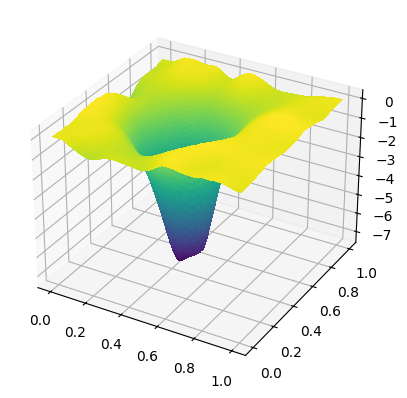

In [32]:
firedrake.trisurf(q_opt);

The optimization procedure has correctly identified the drop in the conductivity of the medium to within our smoothness constraints.
Nonetheless, it's clear in the eyeball norm that the inferred field doesn't completely match the true one.

In [33]:
firedrake.norm(q_opt - q_true) / firedrake.norm(q_true)

0.28636248010146415

What's a little shocking is the degree to which the computed state matches observations despite these departures.
If we plot the computed $u$, it looks very similar to the true value.

In [34]:
q.assign(q_opt)
firedrake.solve(F == 0, u, **opts)

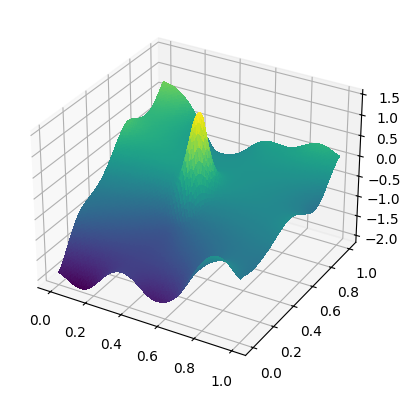

In [35]:
firedrake.trisurf(u);

Moreover, if we compute the model-data misfit and weight it by the standard deviation of the measurement errors, we get a value that's roughly around 1/2.

In [36]:
firedrake.assemble(0.5 * ((u - u_obs) / σ)**2 * dx)

0.5139410915262156

This value is about what we would expect from statistical estimation theory.
Assuming $u$ is an unbiased estimator for the true value of the observable state, the quantity $((u - u^o) / \sigma)^2$ is a $\chi^2$ random variable.
When we integrate over the whole domain and divide by the area (in this case 1), we're effectively summing over independent $\chi^2$ variables and so we should get a value around 1/2.

Recall that we used a measurement error $\sigma$ that was about 2\% of the true signal, which is pretty small.
You can have an awfully good signal-to-noise ratio and yet only be able to infer the conductivity field to within a relative error of 1/4.
These kinds of synthetic experiments are really invaluable for getting some perspective on how good of a result you can expect.